# Course Project - Linear Regression

#### URL: https://www.kaggle.com/c/gb-tutors-expected-math-exam-results

## Import Section

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

## Function "Reduce Memory Usage"

In [2]:
def reduce_memory_usage(df):
    
    # СДЕЛАТЬ ПРОВЕРКУ type(df) == pd.DataFrame
    
    initial_memory_usage = df.memory_usage().sum() / 1024 / 1024
    print(f'Initial memory usage of dataframe:\t{initial_memory_usage:.3} Mb')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            # Можно было бы сделать оптимизацию вплоть до типа "float16", однако данный тип данных,
            # как сообщается от сообщества аналитиков данных, плохо поддерживается некоторыми библиотеками
            
            if str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
        
        else:
            df[col] = df[col].astype('category')
    
    final_memory_usage = df.memory_usage().sum() / 1024 / 1024
    print(f'Final memory usage of dataframe:\t{final_memory_usage:.3} Mb')
    
    comparison = np.round(100 * (initial_memory_usage - final_memory_usage) / initial_memory_usage, 3)
    print(f'Memory usage has been decreased by:\t{comparison} %')
    
    return df

## Path Section

In [3]:
PATH_DATA_TRAIN = r'train.csv'
PATH_DATA_TEST = r'test.csv'

PATH_DATA_RESULT_LR_L1_P2 = r'result_lr_l1_p2.csv'
PATH_DATA_RESULT_LR_L1_P3 = r'result_lr_l1_p3.csv'

# Exploratory Data Analysis

    Id - айди
    age - возраст преподавателя
    years_of_experience - стаж преподавателя
    lesson_price - стоимость урока
    qualification - квалификация преподавателя
    physics - преподает ли физику
    chemistry - преподает ли химию
    biology - преподает ли биологию
    english - преподает ли английский
    geography - преподает ли географию
    history - преподает ли историю
    mean_exam_points - целевое значение, средний балл за экзамен учеников

In [4]:
df_data_train = pd.read_csv(PATH_DATA_TRAIN)

In [5]:
df_data_train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,61
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,76
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57


In [6]:
df_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 937.6 KB


In [7]:
df_data_train.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.878000,1.986800,1699.105000,1.719500,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,63.737300
std,2886.89568,8.043929,1.772213,524.886654,0.792264,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,14.705574
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000
50%,4999.50000,46.000000,2.000000,1500.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000
max,9999.00000,68.000000,10.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


##### Данные выглядят адекватно, не содержат пропусков, выбросов и аномалий.
##### Признак "Id" не потребуется для обучения модели, так как модель должна уловить тенденцию данных и вычислить общие правила прогнозирования, а не индивидуальные для каждого "Id".
##### Признаки "age", "years_of_experience", "lesson_price" и "qualification" следует масштабировать.

# Data Preprocessing

In [8]:
class StandardScaler():
    def __init__(self):
        # Флаг, обучен ли StandardScaler.
        self.fitted = False
        # Словарь для статистик признаков: мат. ожидания и стандартного отклонения.
        self.dict_features = {}
       
    def fit_transform(self, dataframe):
        # Для каждого признака:
        for feature in dataframe.columns:
            # записать статистики в словарь;
            self.dict_features[feature] = [dataframe[feature].mean(), dataframe[feature].std()]
            # выполнить масштабирование с использованием статистик из словаря.
            dataframe[feature] = (dataframe[feature] - self.dict_features[feature][0]) / self.dict_features[feature][1]
        # Установить флаг, что StandardScaler обучен.
        self.fitted = True
        return dataframe
    
    def transform(self, dataframe):
        # Если StandardScaler не обучен:
        if self.fitted is False:
            # вывести сообщение об ошибке.
            raise Exception(f"Cannot transform without already used method 'fit_transform'!")
        # Если StandardScaler обучен:
        else:
            # для каждого признака:
            for feature in dataframe.columns:
                # если признак отсутствует в словаре известных признаков:
                if feature not in self.dict_features.keys():
                    # вывести сообщение об ошибке.
                    raise Exception(f"Unexpected feature '{feature}' has been discovered in DataFrame!")
                # если признак присутствует в словаре известных признаков:
                else:
                    # выполнить масштабирование с использованием статистик из словаря.
                    dataframe[feature] = (dataframe[feature] - self.dict_features[feature][0]) / self.dict_features[feature][1]
        return dataframe

##### Обработка обучающего набора данных.

In [9]:
features_to_standard = ['age', 'years_of_experience', 'lesson_price', 'qualification']

ss = StandardScaler()

df_data_train_preprocessed = df_data_train.copy()
df_data_train_preprocessed[features_to_standard] = ss.fit_transform(df_data_train_preprocessed[features_to_standard].copy())
df_data_train_preprocessed = df_data_train_preprocessed.drop(columns=['Id']).copy()
df_data_train_preprocessed.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,-0.730737,-1.121084,-0.569847,-0.908157,1.0,0.0,0.0,0.0,1.0,0.0,61
1,0.263801,1.135981,2.192654,1.616254,1.0,0.0,0.0,0.0,0.0,0.0,76
2,-0.855055,-1.121084,-0.950881,-0.908157,0.0,0.0,0.0,0.0,0.0,0.0,53
3,0.015167,1.700247,-0.569847,-0.908157,0.0,0.0,0.0,0.0,0.0,0.0,54
4,-0.357785,-0.556818,-0.379330,-0.908157,0.0,0.0,0.0,0.0,0.0,0.0,57


In [10]:
df_data_train_preprocessed.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-1.527667e-17,8.171241e-17,-3.623768e-17,-1.008971e-16,0.375000,0.132900,0.109600,0.053700,0.032100,0.019400,63.737300
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.484147,0.339484,0.312406,0.225436,0.176274,0.137933,14.705574
min,-2.844133e+00,-1.121084e+00,-2.856055e+00,-9.081567e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,-7.307375e-01,-1.121084e+00,-7.603642e-01,-9.081567e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.000000
50%,1.516672e-02,7.448314e-03,-3.793295e-01,3.540486e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,6.367535e-01,5.717145e-01,8.590331e-01,3.540486e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000
max,2.750149e+00,4.521578e+00,4.288345e+00,2.878459e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


##### Обработка тестового набора данных. 

In [11]:
df_data_test = pd.read_csv(PATH_DATA_TEST)

In [12]:
df_data_test_preprocessed = df_data_test.copy()
df_data_test_preprocessed[features_to_standard] = ss.transform(df_data_test_preprocessed[features_to_standard].copy())
df_data_test_preprocessed = df_data_test_preprocessed.drop(columns=['Id']).copy()
df_data_test_preprocessed.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
0,0.015167,0.571714,-1.236657,-0.908157,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.357785,0.571714,0.287481,0.354049,0.0,0.0,0.0,0.0,0.0,0.0
2,0.761071,-0.556818,-0.284071,-0.908157,1.0,0.0,0.0,0.0,0.0,0.0
3,1.382658,2.264513,2.287913,1.616254,1.0,0.0,1.0,0.0,0.0,0.0
4,-0.233468,1.135981,2.764206,1.616254,1.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_data_test_preprocessed = reduce_memory_usage(df_data_test_preprocessed)
df_data_test_preprocessed.info()

Initial memory usage of dataframe:	0.763 Mb
Final memory usage of dataframe:	0.382 Mb
Memory usage has been decreased by:	49.992 %
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10000 non-null  float32
 1   years_of_experience  10000 non-null  float32
 2   lesson_price         10000 non-null  float32
 3   qualification        10000 non-null  float32
 4   physics              10000 non-null  float32
 5   chemistry            10000 non-null  float32
 6   biology              10000 non-null  float32
 7   english              10000 non-null  float32
 8   geography            10000 non-null  float32
 9   history              10000 non-null  float32
dtypes: float32(10)
memory usage: 390.8 KB


In [14]:
df_data_test_preprocessed.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000
mean,0.011785,-0.003837,-0.003829,-0.012748,0.38130,0.123500,0.120100,0.056000,0.031400,0.0184
std,0.989104,1.006249,0.998811,1.001538,0.48573,0.329027,0.325095,0.229933,0.174405,0.1344
min,-2.844133,-1.121084,-2.856055,-0.908157,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000
25%,-0.606420,-1.121084,-0.760364,-0.908157,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000
50%,0.015167,0.007448,-0.379330,0.354049,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000
75%,0.636754,0.571714,0.859033,0.354049,1.00000,0.000000,0.000000,0.000000,0.000000,0.0000
max,2.750149,4.521578,4.478862,2.878459,1.00000,1.000000,1.000000,1.000000,1.000000,1.0000


### Correlation Matrix

<AxesSubplot:>

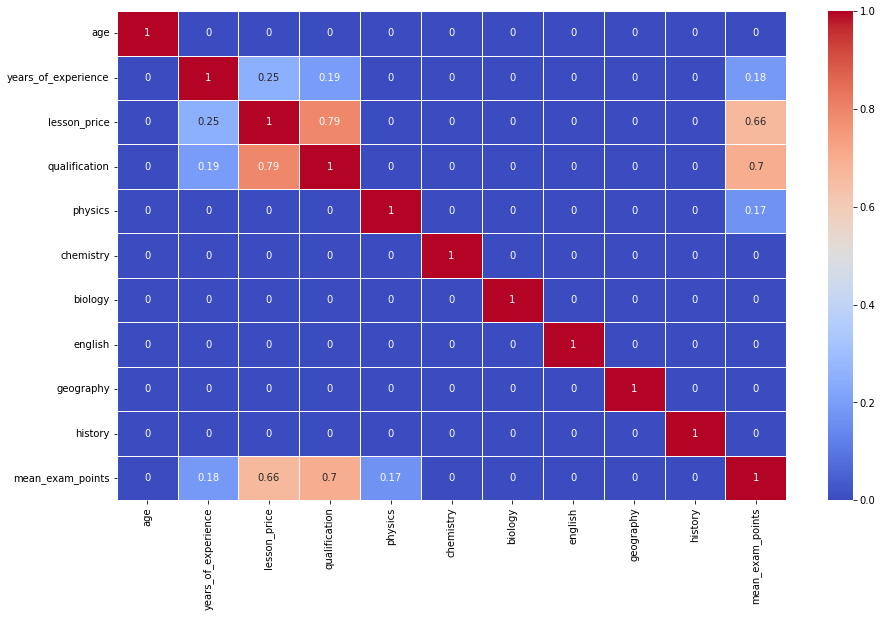

In [15]:
corr_matrix = df_data_train_preprocessed.corr()
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

plt.figure(figsize=[15, 9])
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths='0.5')

##### Только четыре признака демонстрируют линейную корреляцию с целевой переменной:
##### - "years_of_experience";
##### - "lesson_price";
##### - "qualification";
##### - "physics".
##### Возможно, следует рассмотреть данные признаки отдельно.

# Model Building

### RMSE

In [16]:
def RMSE(y_true, y_pred):
    return (sum((y_true - y_pred)**2) / len(y_true))**0.5

### LinearRegressor

In [17]:
class LinearRegressor():
    def __init__(self, learning_rate=1e-2, w_dist=1e-9, emergency_stop=1e+5, regularization=1e-3, messages=True,
                 i_messages=10000, penalty='l2'): 
        # Флаг, обучен ли LinearRegressorL1.
        self.fitted = False
        # Скорость обучения.
        self.learning_rate = learning_rate
        # Расстояние между весами.
        self.w_dist = w_dist
        # Счётчик аварийной остановки.
        self.emergency_stop = emergency_stop
        # Коэффициент регуляризации.
        self.regularization = regularization
        # Флаг, выводить ли сообщения об обучении.
        self.messages = messages
        # Выводить сообщения каждые i_messages итераций.
        self.i_messages = i_messages
        # Веса.
        self.w = 0
        # Выбор метода регуляризации:
        # l1 - L1-регуляризация;
        # l2 - L2-регуляризация(по умолчанию).
        self.penalty = penalty
    
    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        # Количество записей.
        n = X.shape[0]
        
        # Изначальное предположение о весах.
        w = np.zeros_like(a=X_train, shape=X_train.shape[1])
        
        # Вычисляемая разница весов.
        w_dist_calculated = np.inf
        
        # Счётчик итераций.
        i = 0
        
        while w_dist_calculated > self.w_dist:
            # Оценочный вектор ответов.
            y_pred = X_train @ w
            
            # Градиент фунции ошибки.
            dQ = 2/n * X_train.T @ (y_pred - y_train)
            
            # Выбор метода регуляризации:
            if self.penalty == 'l1':
                # Градиент L1-регуляризации.
                dReg = self.regularization * np.sign(w)
            elif self.penalty == 'l2':
                # Градиент L2-регуляризации.
                dReg = self.regularization * w
            else:
                dReg = 0
            
            # Вычисление новых весов.
            w_new = w - self.learning_rate * (dQ + dReg)
            
            # Вычисление новой разницы весов.
            w_dist_calculated = np.linalg.norm(w - w_new, ord=1)
            
            # Переопределение весов.
            w = w_new
            
            # Вывод сообщений о процессе обучения.
            if (self.messages is True) and (i % self.i_messages == 0):
                print(f"Iter:\t{i}\n\tw:\n{w}\n\tRMSE:\t{RMSE(y_train, y_pred)}\n")
            
            # Аварийный выход из цикла обучения.
            if i > self.emergency_stop:
                break
            
            # Счётчик итераций.
            i += 1
        
        i -= 1
        # Вывод финального сообщения.
        if (self.messages is True) and (i % self.i_messages != 0):
            print(f"Iter:\t{i}\n\tw:\n{w}\n\tRMSE:\t{RMSE(y_train, y_pred)}\n")
        
        # Результат обучения: веса признаков и переключения флага обучения.
        self.w = w
        self.fitted = True
    
    def predict(self, X_test):
        # Если LinearRegressorL1 не обучен:
        if self.fitted is False:
            # вывести сообщение об ошибке.
            raise Exception(f"Cannot transform without already used method 'fit'!")
        # Если LinearRegressorL1 обучен:
        else:
            # выполнить прогноз.
            y_pred = X_test @ self.w
            return y_pred

### Train_test_split

In [18]:
X = df_data_train_preprocessed.drop(columns=['mean_exam_points']).copy()
y = df_data_train_preprocessed['mean_exam_points'].copy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((8000, 10), (2000, 10), (8000,), (2000,))

### LinearRegressor - L2

In [19]:
%%time

lr_l2_1 = LinearRegressor(regularization=1e-2, i_messages=10000, penalty='l2')
lr_l2_1.fit(X_train, y_train)

Iter:	0
	w:
[-0.0007483   0.0462714   0.15944749  0.17096088  0.402962    0.13751
  0.113722    0.055924    0.033212    0.01956   ]
	RMSE:	65.4767582810878

Iter:	10000
	w:
[ 0.07079941  0.15577219  4.53988393  6.81208511 54.36185193 33.6993347
 34.50892615 30.72893128 28.51218701 23.79226102]
	RMSE:	44.9535870245583

Iter:	20000
	w:
[ 0.07072583  0.15483169  4.54018687  6.8121263  54.35398034 33.69404479
 34.50019563 30.72782646 28.56338703 24.17648757]
	RMSE:	44.952188734634355

Iter:	30000
	w:
[ 0.07072545  0.15481174  4.54019653  6.81212555 54.35386664 33.69396927
 34.50006137 30.7277846  28.56335758 24.18346174]
	RMSE:	44.95216741332107

Iter:	40000
	w:
[ 0.07072545  0.15481137  4.54019672  6.81212553 54.35386464 33.69396794
 34.50005898 30.72778387 28.56335475 24.1835887 ]
	RMSE:	44.95216703340494

Iter:	40047
	w:
[ 0.07072545  0.15481137  4.54019672  6.81212553 54.35386464 33.69396793
 34.50005898 30.72778387 28.56335475 24.18358874]
	RMSE:	44.95216703327386

Wall time: 3.65 s


In [20]:
y_pred = lr_l2_1.predict(X_valid)
RMSE(y_valid, y_pred)

45.15964318873074

### LinearRegressor - L1

In [21]:
%%time

lr_l1_1 = LinearRegressor(regularization=1e-2, i_messages=10000, penalty='l1')
lr_l1_1.fit(X_train, y_train)

Iter:	0
	w:
[-0.0007483   0.0462714   0.15944749  0.17096088  0.402962    0.13751
  0.113722    0.055924    0.033212    0.01956   ]
	RMSE:	65.4767582810878

Iter:	10000
	w:
[ 0.07524155  0.14570117  4.51297207  6.87484552 54.55287571 34.58468963
 35.77539647 33.6227078  33.22797347 29.78337688]
	RMSE:	44.91837369931865

Iter:	20000
	w:
[ 0.07500012  0.14239186  4.5140866   6.87496593 54.5260248  34.56666508
 35.74549201 33.61821171 33.39086066 31.11675926]
	RMSE:	44.91775474673634

Iter:	30000
	w:
[ 0.07499662  0.14220321  4.51417821  6.87495867 54.52495445 34.56595408
 35.74422694 33.61781788 33.39048668 31.18258689]
	RMSE:	44.91774512844095

Iter:	40000
	w:
[ 0.0749965   0.14219372  4.51418298  6.87495822 54.52490303 34.56591995
 35.74416558 33.6177992  33.39041337 31.18584542]
	RMSE:	44.91774470643329

Iter:	50000
	w:
[ 0.0749965   0.14219325  4.51418322  6.87495819 54.5249005  34.56591827
 35.74416255 33.61779828 33.39040939 31.18600677]
	RMSE:	44.917744685696945

Iter:	53342
	w:
[

In [22]:
y_pred = lr_l1_1.predict(X_valid)
RMSE(y_valid, y_pred)

45.118407946824966

##### Метрика RMSE = ~45.1, что является большой погрешностью, при средних значениях целевой переменной ~63.7.

##### Попробуем обучить модель и выполнить валидацию используя только признаки с коэффициентом линейной корреляции более 0.1.

In [23]:
features_important = ['years_of_experience', 'lesson_price', 'qualification', 'physics']

### LinearRegressor - L2

In [24]:
%%time

lr_l2_2 = LinearRegressor(regularization=1e-6, i_messages=10000, penalty='l2')
lr_l2_2.fit(X_train[features_important], y_train)

Iter:	0
	w:
[0.0462714  0.15944749 0.17096088 0.402962  ]
	RMSE:	65.4767582810878

Iter:	4724
	w:
[6.01192480e-02 5.16742797e+00 6.10665511e+00 6.70509858e+01]
	RMSE:	49.815619241814176

Wall time: 303 ms


In [25]:
y_pred = lr_l2_2.predict(X_valid[features_important])
RMSE(y_valid, y_pred)

50.03094019213317

##### Метрика ухудшилась, значит остальные признаки важны для обучения и проноза.

##### Возможно, модель не может уловить нелинейные зависимости, попробуем выполнить полиномизацию. Также добавим единичный признак для смещения.

### Polynomization_2

In [26]:
def Polynomization_2(dataframe_original, bias=True):
    dataframe = dataframe_original.copy()
    list_features_1 = dataframe.columns
    list_features_2 = list_features_1.copy()
    
    for feature_1 in list_features_1:
        for feature_2 in list_features_2:
            dataframe[f'{feature_1}_{feature_2}'] = dataframe[feature_1] * dataframe[feature_2]
        if len(list_features_2) > 1:
            list_features_2 = list_features_2[1:]
    
    if bias == True:
        dataframe['bias'] = 1
    
    dataframe = dataframe.drop(columns=list_features_1)
    
    return dataframe

##### Бинарные признаки "physics", "chemistry", "biology", "english", "geography", "history" не имеет смысла подвергать полиномизации, так как их значения [0; 1] при умножении дадут избыточные линейнозависимые признаки.

##### Обработаем только признаки "age", "years_of_experience", "lesson_price", "qualification".

In [27]:
feature_to_polynomization = ['age', 'years_of_experience', 'lesson_price', 'qualification']

In [28]:
X_train_2 = Polynomization_2(X_train[feature_to_polynomization])
X_train_p2 = X_train.join(X_train_2)
X_train_p2 = reduce_memory_usage(X_train_p2)
X_train_p2.info()

Initial memory usage of dataframe:	1.59 Mb
Final memory usage of dataframe:	0.931 Mb
Memory usage has been decreased by:	41.621 %
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 2694 to 235
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      8000 non-null   float32
 1   years_of_experience                      8000 non-null   float32
 2   lesson_price                             8000 non-null   float32
 3   qualification                            8000 non-null   float32
 4   physics                                  8000 non-null   float32
 5   chemistry                                8000 non-null   float32
 6   biology                                  8000 non-null   float32
 7   english                                  8000 non-null   float32
 8   geography                                8000 non-null  

In [29]:
X_valid_2 = Polynomization_2(X_valid[feature_to_polynomization].copy())
X_valid_2p = X_valid.join(X_valid_2)
X_valid_2p = reduce_memory_usage(X_valid_2p)
X_valid_2p.info()

Initial memory usage of dataframe:	0.399 Mb
Final memory usage of dataframe:	0.233 Mb
Memory usage has been decreased by:	41.618 %
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 9953 to 2745
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      2000 non-null   float32
 1   years_of_experience                      2000 non-null   float32
 2   lesson_price                             2000 non-null   float32
 3   qualification                            2000 non-null   float32
 4   physics                                  2000 non-null   float32
 5   chemistry                                2000 non-null   float32
 6   biology                                  2000 non-null   float32
 7   english                                  2000 non-null   float32
 8   geography                                2000 non-null

### LinearRegressor - L1

In [30]:
%%time

lr_l1_3 = LinearRegressor(regularization=1e-2, i_messages=10000, penalty='l1')
lr_l1_3.fit(X_train_p2, y_train)

Iter:	0
	w:
[-7.48302045e-04  4.62713856e-02  1.59447494e-01  1.70960895e-01
  4.02961990e-01  1.37509997e-01  1.13721997e-01  5.59239986e-02
  3.32119992e-02  1.95599995e-02  1.02149808e+00  8.49662620e-02
 -3.61574296e-03  2.30823353e-04  1.07303731e+00  3.30317997e-01
  2.64584707e-01  1.17315423e+00  9.37401769e-01  1.14966876e+00
  1.02051397e+00]
	RMSE:	65.4767582810878

Iter:	10000
	w:
[ 0.08523076 -0.09292667  4.22333201  6.14479033  5.30743547  0.27009674
  1.33069516  0.975129    0.44961176  0.86834294  0.06678506 -0.12037557
  0.12327787 -0.06257593  0.29896287 -1.46514133  0.91270801 -1.08396355
  4.58430829 -1.10049003 59.86551833]
	RMSE:	9.562973943201275

Iter:	20000
	w:
[ 0.08524283 -0.09275559  4.22322636  6.14503774  5.30741107  0.26995604
  1.33087104  0.9734246   0.43373364  0.82924014  0.06672855 -0.12033561
  0.12322569 -0.06255494  0.29883637 -1.46500261  0.91259254 -1.08396825
  4.58439028 -1.10086054 59.86739976]
	RMSE:	9.563007769492168

Iter:	30000
	w:
[ 0.08

In [31]:
y_pred = lr_l1_3.predict(X_valid_2p)
RMSE(y_valid, y_pred)

9.476218322450189

##### Полиномизация помогла сократить ошибку с ~45.16 до ~9.48.

### LinearRegressor - L2

In [32]:
%%time

lr_l2_3 = LinearRegressor(regularization=1e-2, i_messages=10000, penalty='l2')
lr_l2_3.fit(X_train_p2, y_train)

Iter:	0
	w:
[-7.48302045e-04  4.62713856e-02  1.59447494e-01  1.70960895e-01
  4.02961990e-01  1.37509997e-01  1.13721997e-01  5.59239986e-02
  3.32119992e-02  1.95599995e-02  1.02149808e+00  8.49662620e-02
 -3.61574296e-03  2.30823353e-04  1.07303731e+00  3.30317997e-01
  2.64584707e-01  1.17315423e+00  9.37401769e-01  1.14966876e+00
  1.02051397e+00]
	RMSE:	65.4767582810878

Iter:	10000
	w:
[ 0.07433848 -0.38838309  4.10729357  5.79236021  5.73198553  0.68103247
  1.65149377  1.28728051  0.8768497   1.23106512  0.24787187 -0.19263034
  0.10684594 -0.08165552  0.56720648 -1.48353018  0.85379916 -0.67134523
  4.04824963 -0.3274928  58.02783744]
	RMSE:	9.598271356572461

Iter:	20000
	w:
[ 0.07434179 -0.38835856  4.10728005  5.79241181  5.73197686  0.68099804
  1.65151393  1.2868101   0.87237869  1.22457541  0.24785778 -0.19262205
  0.10684661 -0.08166147  0.56718625 -1.48350976  0.85377909 -0.6713552
  4.04828984 -0.32758351 58.02824857]
	RMSE:	9.59826363472736

Iter:	30000
	w:
[ 0.0743

In [33]:
y_pred = lr_l2_3.predict(X_valid_2p)
RMSE(y_valid, y_pred)

9.539387199251575

##### L1-регуляризация показала лучшую метрику, поэтому используем её для прогноза на тестовых данных.

### X_test

In [34]:
X_test = df_data_test_preprocessed.copy()
X_test_2 = Polynomization_2(X_test[feature_to_polynomization].copy())
X_test_2p = X_test.join(X_test_2)
X_test_2p = reduce_memory_usage(X_test_2p)
X_test_2p.info()

Initial memory usage of dataframe:	0.839 Mb
Final memory usage of dataframe:	0.773 Mb
Memory usage has been decreased by:	7.953 %
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      10000 non-null  float32
 1   years_of_experience                      10000 non-null  float32
 2   lesson_price                             10000 non-null  float32
 3   qualification                            10000 non-null  float32
 4   physics                                  10000 non-null  float32
 5   chemistry                                10000 non-null  float32
 6   biology                                  10000 non-null  float32
 7   english                                  10000 non-null  float32
 8   geography                                10000 non-null  

In [35]:
y_test = lr_l1_3.predict(X_test_2p)

In [36]:
y_test = pd.DataFrame(y_test, columns=['mean_exam_points'])
y_test['Id'] = df_data_test['Id']
y_test = y_test[['Id', 'mean_exam_points']].copy()
y_test.head()

,Id,mean_exam_points
0,10000,52.522446
1,10001,63.482730
2,10002,59.126941
3,10003,91.693582
4,10004,93.419307


In [37]:
y_test.shape

(10000, 2)

In [38]:
y_test.to_csv(PATH_DATA_RESULT_LR_L1_P2, sep=',', index=False)

##### R2-score Kaggle 0.89766

##### Попробуем применить полиномизацию третьей степени.

### Polynomization_3

In [39]:
def Polynomization_3(dataframe_original, bias=True):
    dataframe = dataframe_original.copy()
    list_features_1 = dataframe.columns
    list_features_2 = list_features_1.copy()
    
    for feature_1 in list_features_1:
        for feature_2 in list_features_2:
            
            dataframe[f'{feature_1}_{feature_2}'] = dataframe[feature_1] * dataframe[feature_2]
            
            for feature_3 in list_features_1:
                dataframe[f'{feature_1}_{feature_2}_{feature_3}'] = dataframe[feature_1] * dataframe[feature_2] \
                    * dataframe[feature_2] 
                
        if len(list_features_2) > 1:
            list_features_2 = list_features_2[1:]
    
    if bias == True:
        dataframe['bias'] = 1
    
    dataframe = dataframe.drop(columns=list_features_1)
    
    return dataframe

In [40]:
X_train_3 = Polynomization_3(X_train[feature_to_polynomization])
X_train_p3 = X_train.join(X_train_3)
X_train_p3 = reduce_memory_usage(X_train_p3)
X_train_p3.info()

Initial memory usage of dataframe:	4.04 Mb
Final memory usage of dataframe:	2.15 Mb
Memory usage has been decreased by:	46.689 %
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 2694 to 235
Data columns (total 61 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   age                                                          8000 non-null   float32
 1   years_of_experience                                          8000 non-null   float32
 2   lesson_price                                                 8000 non-null   float32
 3   qualification                                                8000 non-null   float32
 4   physics                                                      8000 non-null   float32
 5   chemistry                                                    8000 non-null   float32
 6   biology                              

In [41]:
X_valid_3 = Polynomization_3(X_valid[feature_to_polynomization].copy())
X_valid_3p = X_valid.join(X_valid_3)
X_valid_3p = reduce_memory_usage(X_valid_3p)
X_valid_3p.info()

Initial memory usage of dataframe:	1.01 Mb
Final memory usage of dataframe:	0.538 Mb
Memory usage has been decreased by:	46.688 %
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 9953 to 2745
Data columns (total 61 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   age                                                          2000 non-null   float32
 1   years_of_experience                                          2000 non-null   float32
 2   lesson_price                                                 2000 non-null   float32
 3   qualification                                                2000 non-null   float32
 4   physics                                                      2000 non-null   float32
 5   chemistry                                                    2000 non-null   float32
 6   biology                            

### LinearRegressor - L1

In [42]:
%%time

lr_l1_4 = LinearRegressor(regularization=1e-2, i_messages=10000, penalty='l1', learning_rate=1e-3)
lr_l1_4.fit(X_train_p3, y_train)

Iter:	0
	w:
[-7.48302045e-05  4.62713856e-03  1.59447494e-02  1.70960895e-02
  4.02961990e-02  1.37509997e-02  1.13721997e-02  5.59239986e-03
  3.32119992e-03  1.95599995e-03  1.02149808e-01 -3.52662684e-03
 -3.52662684e-03 -3.52662684e-03 -3.52662684e-03  8.49662620e-03
  2.33154277e-02  2.33154277e-02  2.33154277e-02  2.33154277e-02
 -3.61574296e-04  3.46358213e-03  3.46358213e-03  3.46358213e-03
  3.46358213e-03  2.30823353e-05 -1.75342439e-03 -1.75342439e-03
 -1.75342439e-03 -1.75342439e-03  1.07303731e-01  8.03840416e-02
  8.03840416e-02  8.03840416e-02  8.03840416e-02  3.30317997e-02
  7.86823101e-02  7.86823101e-02  7.86823101e-02  7.86823101e-02
  2.64584707e-02  3.41183313e-02  3.41183313e-02  3.41183313e-02
  3.41183313e-02  1.17315423e-01  1.31631395e-01  1.31631395e-01
  1.31631395e-01  1.31631395e-01  9.37401769e-02  8.38784360e-02
  8.38784360e-02  8.38784360e-02  8.38784360e-02  1.14966876e-01
  9.92822073e-02  9.92822073e-02  9.92822073e-02  9.92822073e-02
  1.02051397e

Iter:	80000
	w:
[-3.64757621e-01  1.08475163e-01  6.74315043e+00  7.13858733e+00
  5.15783189e+00  3.89885891e-01  1.41676995e+00  7.46736456e-01
  6.40587915e-01  1.09346716e+00  5.60367103e-02  1.71548944e-02
  1.71548944e-02  1.71548944e-02  1.71548944e-02 -2.05443015e-01
  2.26897887e-02  2.26897887e-02  2.26897887e-02  2.26897887e-02
  1.66627671e-01  5.22777073e-02  5.22777073e-02  5.22777073e-02
  5.22777073e-02 -1.82255974e-01 -4.72549045e-06 -4.72549045e-06
 -4.72549045e-06 -4.72549045e-06  4.20091335e-01 -1.87141126e-02
 -1.87141126e-02 -1.87141126e-02 -1.87141126e-02 -2.63941032e-01
 -1.73252435e-01 -1.73252435e-01 -1.73252435e-01 -1.73252435e-01
  2.46641048e-01  1.06691898e-01  1.06691898e-01  1.06691898e-01
  1.06691898e-01  4.11857744e-01 -5.79661523e-02 -5.79661523e-02
 -5.79661523e-02 -5.79661523e-02  6.02126600e+00 -8.45822047e-01
 -8.45822047e-01 -8.45822047e-01 -8.45822047e-01  3.42203789e-06
  7.95757427e-02  7.95757427e-02  7.95757427e-02  7.95757427e-02
  5.79952

In [43]:
y_pred = lr_l1_4.predict(X_valid_3p)
RMSE(y_valid, y_pred)

9.26930400393148

##### Полиномизация третьей степени помогла сократить ошибку с ~9.48 до ~9.27.

### LinearRegressor - L2

In [44]:
%%time

lr_l2_4 = LinearRegressor(regularization=1e-2, i_messages=10000, penalty='l2', learning_rate=1e-3)
lr_l2_4.fit(X_train_p3, y_train)

Iter:	0
	w:
[-7.48302045e-05  4.62713856e-03  1.59447494e-02  1.70960895e-02
  4.02961990e-02  1.37509997e-02  1.13721997e-02  5.59239986e-03
  3.32119992e-03  1.95599995e-03  1.02149808e-01 -3.52662684e-03
 -3.52662684e-03 -3.52662684e-03 -3.52662684e-03  8.49662620e-03
  2.33154277e-02  2.33154277e-02  2.33154277e-02  2.33154277e-02
 -3.61574296e-04  3.46358213e-03  3.46358213e-03  3.46358213e-03
  3.46358213e-03  2.30823353e-05 -1.75342439e-03 -1.75342439e-03
 -1.75342439e-03 -1.75342439e-03  1.07303731e-01  8.03840416e-02
  8.03840416e-02  8.03840416e-02  8.03840416e-02  3.30317997e-02
  7.86823101e-02  7.86823101e-02  7.86823101e-02  7.86823101e-02
  2.64584707e-02  3.41183313e-02  3.41183313e-02  3.41183313e-02
  3.41183313e-02  1.17315423e-01  1.31631395e-01  1.31631395e-01
  1.31631395e-01  1.31631395e-01  9.37401769e-02  8.38784360e-02
  8.38784360e-02  8.38784360e-02  8.38784360e-02  1.14966876e-01
  9.92822073e-02  9.92822073e-02  9.92822073e-02  9.92822073e-02
  1.02051397e

Iter:	80000
	w:
[-4.25918958e-01  1.10856648e-01  6.50709758e+00  7.45562370e+00
  5.54791352e+00  7.60956551e-01  1.73480472e+00  1.03095159e+00
  1.05412433e+00  1.39845344e+00  2.45936982e-01  2.03755244e-02
  2.03755244e-02  2.03755244e-02  2.03755244e-02 -2.48392515e-01
  2.32373630e-02  2.32373630e-02  2.32373630e-02  2.32373630e-02
  2.42469045e-01  6.94729391e-02  6.94729391e-02  6.94729391e-02
  6.94729391e-02 -2.30361397e-01 -3.45066497e-03 -3.45066497e-03
 -3.45066497e-03 -3.45066497e-03  1.05199686e+00 -6.31931056e-02
 -6.31931056e-02 -6.31931056e-02 -6.31931056e-02 -1.84460802e-01
 -2.46716804e-01 -2.46716804e-01 -2.46716804e-01 -2.46716804e-01
  1.08588664e-01  1.46857354e-01  1.46857354e-01  1.46857354e-01
  1.46857354e-01  1.33325110e+00 -6.61758421e-02 -6.61758421e-02
 -6.61758421e-02 -6.61758421e-02  4.91814799e+00 -8.14871045e-01
 -8.14871045e-01 -8.14871045e-01 -8.14871045e-01  1.88537560e+00
 -7.86330670e-02 -7.86330670e-02 -7.86330670e-02 -7.86330670e-02
  5.52399

In [45]:
y_pred = lr_l2_4.predict(X_valid_3p)
RMSE(y_valid, y_pred)

9.344861822422317

##### L1-регуляризация показала лучшую метрику, поэтому используем её для прогноза на тестовых данных.

### X_test

In [46]:
X_test = df_data_test_preprocessed.copy()
X_test_3 = Polynomization_3(X_test[feature_to_polynomization].copy())
X_test_3p = X_test.join(X_test_3)
X_test_3p = reduce_memory_usage(X_test_3p)
X_test_3p.info()

Initial memory usage of dataframe:	2.37 Mb
Final memory usage of dataframe:	2.3 Mb
Memory usage has been decreased by:	2.822 %
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 61 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   age                                                          10000 non-null  float32
 1   years_of_experience                                          10000 non-null  float32
 2   lesson_price                                                 10000 non-null  float32
 3   qualification                                                10000 non-null  float32
 4   physics                                                      10000 non-null  float32
 5   chemistry                                                    10000 non-null  float32
 6   biology                                 

In [47]:
y_test = lr_l1_4.predict(X_test_3p)

In [48]:
y_test = pd.DataFrame(y_test, columns=['mean_exam_points'])
y_test['Id'] = df_data_test['Id']
y_test = y_test[['Id', 'mean_exam_points']].copy()
y_test.head()

,Id,mean_exam_points
0,10000,54.446879
1,10001,63.363897
2,10002,56.909613
3,10003,91.097012
4,10004,90.523352


In [49]:
y_test.shape

(10000, 2)

In [50]:
y_test.to_csv(PATH_DATA_RESULT_LR_L1_P3, sep=',', index=False)

##### R2-score Kaggle 0.92821